# **Minimum, Maximum and Mixture**
In the previous chapter we computed distributions of sums. In this chapter, we’ll compute distributions of minimums and maximums, and use them to solve both forward and inverse problems.

Then we’ll look at distributions that are mixtures of other distributions, which will turn out to be particularly useful for making predictions.

But we’ll start with a powerful tool for working with distributions, the cumulative distribution function.

##**Cumulative Distribution Functions**
So far we have been using probability mass functions to represent distributions. A useful alternative is the cumulative distribution function, or CDF.

As an example, I’ll use the posterior distribution from the Euro problem, which we computed in [BayesianEstimation](https://github.com/iamzehan/think_bayes/blob/main/Chapter%204/Ch%20%204%20Studies.ipynb).

In [60]:
import numpy as np
import pandas as pd
try:
  from empiricaldist import Pmf
except:
  !pip install empiricaldist
hypos = np.linspace(0, 1, 101)
pmf = Pmf(1, hypos)
data = 140, 250

Here's the update:

In [3]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()

In [4]:
update_binomial(pmf, data)

In [5]:
cumulative = pmf.cumsum()

In [6]:
import matplotlib.pyplot as plt
def decorate_euro(title):
    plt.xlabel('Proportion of heads (x)')
    plt.ylabel('Probability')
    plt.title(title)

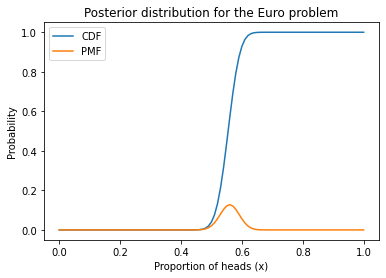

In [7]:
cumulative.plot(label='CDF')
pmf.plot(label='PMF')
decorate_euro(title='Posterior distribution for the Euro problem')
plt.legend(['CDF','PMF'])

The range of the CDF is always from 0 to 1, in contrast with the PMF, where the maximum can be any probability.

The result from `cumsum` is a Pandas `Series`, so we can use the bracket operator to select an element:

In [8]:
cumulative[0.61]

0.9638303193984253

The result is about 0.96, which means that the total probability of all quantities less than or equal to 0.61 is 96%.

To go the other way — to look up a probability and get the corresponding quantile — we can use interpolation:

In [9]:
from scipy.interpolate import interp1d

ps = cumulative.values
qs = cumulative.index

interp = interp1d(ps, qs)
interp(0.96)

array(0.60890171)

The result is about 0.61, so that confirms that the 96th percentile of this distribution is 0.61.

empiricaldist provides a class called Cdf that represents a cumulative distribution function. Given a Pmf, you can compute a Cdf like this:

In [10]:
cdf = pmf.make_cdf()

In [11]:
cdf[0.61]

0.9638303193984253

But if you look up a quantity that’s not in the distribution, you get a KeyError.

In [12]:
try:
    cdf[0.615]
except KeyError as e:
    print(repr(e))

KeyError(0.615)


To avoid this problem, you can call a Cdf as a function, using parentheses. If the argument does not appear in the Cdf, it interpolates between quantities.

In [13]:
cdf(0.615)

array(0.96383032)

Going the other way, you can use quantile to look up a cumulative probability and get the corresponding quantity:

In [14]:
cdf.quantile(0.9638303)

array(0.61)

Cdf also provides credible_interval, which computes a credible interval that contains the given probability:

In [15]:
cdf.credible_interval(0.9)

array([0.51, 0.61])

CDFs and PMFs are equivalent in the sense that they contain the same information about the distribution, and you can always convert from one to the other. Given a Cdf, you can get the equivalent Pmf like this:

In [16]:
pmf = cdf.make_pmf()

`make_pmf` uses `np.diff` to compute differences between consecutive cumulative probabilities.

One reason Cdf objects are useful is that they compute quantiles efficiently. Another is that they make it easy to compute the distribution of a maximum or minimum, as we’ll see in the next section.

## **Best Three of Four**


---


In Dungeons & Dragons, each character has six attributes: strength, intelligence, wisdom, dexterity, constitution, and charisma.

To generate a new character, players roll four 6-sided dice for each attribute and add up the best three. For example, if I roll for strength and get 1, 2, 3, 4 on the dice, my character’s strength would be the sum of 2, 3, and 4, which is 9.

As an exercise, let’s figure out the distribution of these attributes. Then, for each character, we’ll figure out the distribution of their best attribute.

I’ll import two functions from the previous chapter: `make_die`, which makes a `Pmf` that represents the outcome of rolling a die, and `add_dist_seq`, which takes a sequence of Pmf objects and computes the distribution of their sum.

Here’s a Pmf that represents a six-sided die and a sequence with three references to it.

In [17]:
def make_die(sides):
    outcomes = np.arange(1, sides+1)
    die = Pmf(1/sides, outcomes)
    return die

In [18]:
def add_dist_seq(seq):
    """Compute Pmf of the sum of values from seq."""
    total = seq[0]
    for other in seq[1:]:
        total = total.add_dist(other)
    return total

In [19]:
die = make_die(6)
dice = [die] * 3

In [20]:
pmf_3d6 = add_dist_seq(dice)

Text(0, 0.5, 'PMF')

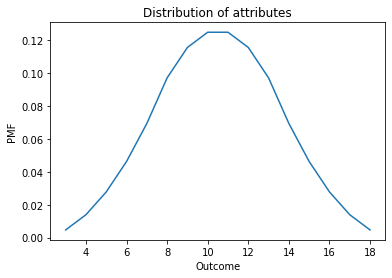

In [21]:
pmf_3d6.plot()
plt.title('Distribution of attributes')
plt.xlabel('Outcome')
plt.ylabel('PMF')

If we roll four dice and add up the best three, computing the distribution of the sum is a bit more complicated. I’ll estimate the distribution by simulating 10,000 rolls.

First I’ll create an array of random values from 1 to 6, with 10,000 rows and 4 columns:

In [22]:
n = 10000
a = np.random.randint(1, 7, size=(n, 4))

To find the best three outcomes in each row, I’ll use sort with axis=1, which sorts the rows in ascending order.

In [23]:
a.sort(axis=1)

Finally, I’ll select the last three columns and add them up.

In [24]:
t = a[:, 1:].sum(axis=1)

In [25]:
pmf_best3 = Pmf.from_seq(t)

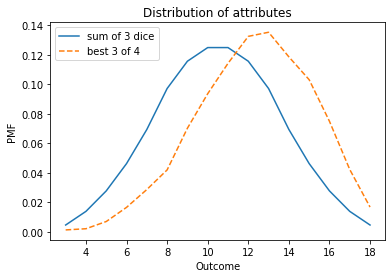

In [26]:
pmf_3d6.plot(label='sum of 3 dice')
pmf_best3.plot(label='best 3 of 4', style='--')
plt.title('Distribution of attributes')
plt.xlabel('Outcome')
plt.ylabel('PMF')
plt.legend(['sum of 3 dice','best 3 of 4'])

As you might expect, choosing the best three out of four tends to yield higher values.

Next we’ll find the distribution for the maximum of six attributes, each the sum of the best three of four dic

## **Maximum**
---
To compute the distribution of a maximum or minimum, we can make good use of the cumulative distribution function. First, I’ll compute the Cdf of the best three of four distribution:

In [27]:
cdf_best3 = pmf_best3.make_cdf()

Recall that `Cdf(x)` is the sum of probabilities for quantities less than or equal to x. Equivalently, it is the probability that a random value chosen from the distribution is less than or equal to `x`.

Now suppose I draw 6 values from this distribution. The probability that all 6 of them are less than or equal to `x` is `Cdf(x)` raised to the 6th power, which we can compute like this:

In [28]:
cdf_best3**6

3     4.826809e-18
4     1.544804e-15
5     1.265319e-12
6     3.874205e-10
7     2.986284e-08
8     8.696958e-07
9     2.248307e-05
10    3.212346e-04
11    2.825707e-03
12    1.730845e-02
13    7.133706e-02
14    1.968441e-01
15    4.215086e-01
16    6.938424e-01
17    9.033400e-01
18    1.000000e+00
Name: , dtype: float64

If all 6 values are less than or equal to `x`, that means that their `maximum` is less than or equal to `x`. So the result is the CDF of their `maximum`. We can convert it to a `Cdf` object, like this:

In [29]:
from empiricaldist import Cdf
cdf_max6 = Cdf(cdf_best3**6)

And compute the equivalent Pmf like this:

In [30]:
pmf_max6 = cdf_max6.make_pmf()

The following figure shows the result.

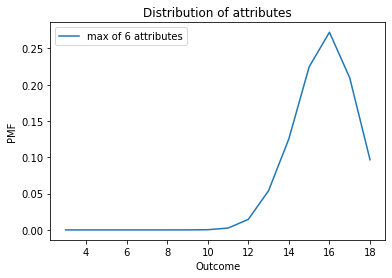

In [31]:
pmf_max6.plot(label='max of 6 attributes')
plt.title('Distribution of attributes')
plt.xlabel('Outcome')
plt.ylabel('PMF')
plt.legend(['max of 6 attributes'])

Most characters have at least one attribute greater than 12; almost 10% of them have an 18.

The following figure shows the CDFs for the three distributions we have computed.

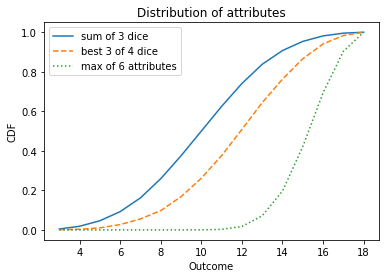

In [32]:
import matplotlib.pyplot as plt

cdf_3d6 = pmf_3d6.make_cdf()
cdf_3d6.plot(label='sum of 3 dice')

cdf_best3 = pmf_best3.make_cdf()
cdf_best3.plot(label='best 3 of 4 dice', style='--')

cdf_max6.plot(label='max of 6 attributes', style=':')
plt.title('Distribution of attributes')
plt.xlabel('Outcome')
plt.ylabel('CDF')
plt.legend(['sum of 3 dice','best 3 of 4 dice','max of 6 attributes'])

Cdf provides max_dist, which does the same computation, so we can also compute the Cdf of the maximum like this:

In [33]:
cdf_max_dist6 = cdf_best3.max_dist(6)

## **Minimum**
---
In the previous section we computed the distribution of a character’s best attribute. Now let’s compute the distribution of the worst.

To compute the distribution of the minimum, we’ll use the complementary CDF, which we can compute like this:

In [34]:
prob_gt = 1 - cdf_best3

As the variable name suggests, the complementary CDF is the probability that a value from the distribution is greater than `x`. If we draw 6 values from the distribution, the probability that all 6 exceed `x`is:

In [35]:
prob_gt6 = prob_gt**6

If all 6 exceed `x`, that means their minimum exceeds `x`, so `prob_gt6` is the complementary CDF of the minimum. And that means we can compute the CDF of the minimum like this:

In [36]:
prob_le6 = 1 - prob_gt6

The result is a Pandas Series that represents the CDF of the minimum of six attributes. We can put those values in a Cdf object like this:

In [37]:
cdf_min6 = Cdf(prob_le6)

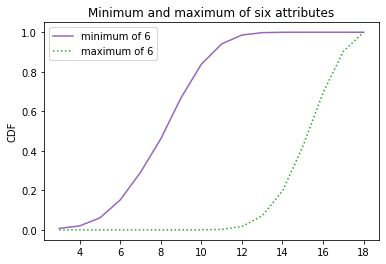

In [39]:
cdf_min6.plot(color='C4', label='minimum of 6')
cdf_max6.plot(color='C2', label='maximum of 6', style=':')
plt.title('Minimum and maximum of six attributes')
plt.ylabel('CDF');
plt.legend(['minimum of 6','maximum of 6'])

`Cdf` provides `min_dist`, which does the same computation, so we can also compute the `Cdf` of the minimum like this:

In [40]:
cdf_min_dist6 = cdf_best3.min_dist(6)

And we can confirm that the differences are small.

In [41]:
np.allclose(cdf_min_dist6, cdf_min6)

True

In the exercises at the end of this chapter, you’ll use distributions of the minimum and maximum to do Bayesian inference. But first we’ll see what happens when we mix distributions.

##**Mixture**
---
In this section I’ll show how we can compute a distribution which is a mixture of other distributions. I’ll explain what that means with some simple examples; then, more usefully, we’ll see how these mixtures are used to make predictions.

Here’s another example inspired by Dungeons & Dragons:

* Suppose your character is armed with a dagger in one hand and a short sword in the other.

* During each round, you attack a monster with one of your two weapons, chosen at random.

* The dagger causes one 4-sided die of damage; the short sword causes one 6-sided die of damage.

What is the distribution of damage you inflict in each round?

To answer this question, I’ll make a Pmf to represent the 4-sided and 6-sided dice:

In [42]:
d4 = make_die(4)
d6 = make_die(6)

Now, let’s compute the probability you inflict 1 point of damage.

* If you attacked with the dagger, it’s 1/4.

* If you attacked with the short sword, it’s 1/6.

Because the probability of choosing either weapon is 1/2, the total probability is the average:

In [43]:
prob_1 = (d4(1) + d6(1)) / 2
prob_1

0.20833333333333331

For the outcomes 2, 3, and 4, the probability is the same, but for 5 and 6 it’s different, because those outcomes are impossible with the 4-sided die.

In [44]:
prob_6 = (d4(6) + d6(6)) / 2
prob_6

0.08333333333333333

To compute the distribution of the mixture, we could loop through the possible outcomes and compute their probabilities.

But we can do the same computation using the + operator:

In [45]:
mix1 = (d4 + d6) / 2

Here’s what the mixture of these distributions looks like.

Text(0, 0.5, 'PMF')

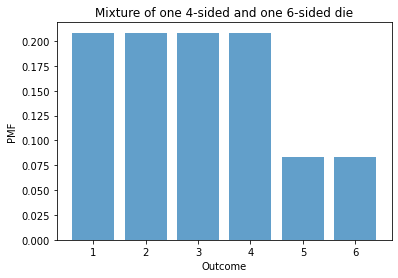

In [46]:
mix1.bar(alpha=0.7)
plt.title('Mixture of one 4-sided and one 6-sided die')
plt.xlabel('Outcome')
plt.ylabel('PMF')

Now suppose you are fighting three monsters:

* One has a club, which causes one 4-sided die of damage.

* One has a mace, which causes one 6-sided die.

* And one has a quarterstaff, which also causes one 6-sided die.

Because the melee is disorganized, you are attacked by one of these monsters each round, chosen at random. To find the distribution of the damage they inflict, we can compute a weighted average of the distributions, like this:

In [47]:
mix2 = (d4 + 2*d6) / 3

Text(0, 0.5, 'PMF')

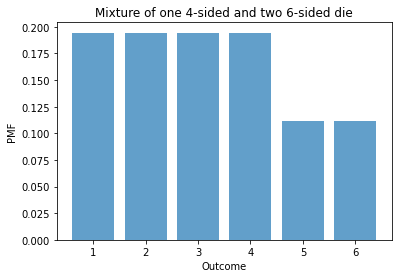

In [48]:
mix2.bar(alpha=0.7)
plt.title('Mixture of one 4-sided and two 6-sided die')
plt.xlabel('Outcome')
plt.ylabel('PMF')

In this section we used the + operator, which adds the probabilities in the distributions, not to be confused with Pmf.add_dist, which computes the distribution of the sum of the distributions.

To demonstrate the difference, I’ll use `Pmf.add_dist` to compute the distribution of the total damage done per round, which is the sum of the two mixtures:

In [49]:
total_damage = Pmf.add_dist(mix1, mix2)

Text(0, 0.5, 'PMF')

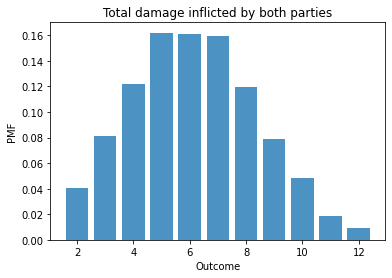

In [54]:
total_damage.bar(alpha=0.8)
plt.title('Total damage inflicted by both parties')
plt.xlabel('Outcome')
plt.ylabel('PMF')

## **General Mixtures**
---
In the previous section we computed mixtures in an _ad hoc_ way. Now we’ll see a more general solution. In future chapters, we’ll use this solution to generate predictions for real-world problems, not just role-playing games. But if you’ll bear with me, we’ll continue the previous example for one more section.

Suppose three more monsters join the combat, each of them with a battle axe that causes one 8-sided die of damage. Still, only one monster attacks per round, chosen at random, so the damage they inflict is a mixture of:

* One 4-sided die,

* Two 6-sided dice, and

* Three 8-sided dice.

I’ll use a Pmf to represent a randomly chosen monster:

In [61]:
hypos = [4,6,8]
counts = [1,2,3]
pmf_dice = Pmf(counts, hypos)
pmf_dice.normalize()
pmf_dice

,probs
4,0.166667
6,0.333333
8,0.500000


This distribution represents the number of sides on the die we’ll roll and the probability of rolling each one. For example, one of the six monsters has a dagger, so the probability is 1/6 that we roll a 4-sided die.

Next I’ll make a sequence of Pmf objects to represent the dice:

In [62]:
dice = [make_die(sides) for sides in hypos]

In [64]:
dist=pd.DataFrame(dice)
dist

,1,2,3,4,5,6,7,8
,0.250000,0.250000,0.250000,0.250000,NaN,NaN,NaN,NaN
,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,NaN,NaN
,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


The result is a DataFrame with one row for each distribution and one column for each possible outcome. Not all rows are the same length, so Pandas fills the extra spaces with the special value NaN, which stands for “not a number”. We can use fillna to replace the NaN values with 0.

The next step is to multiply each row by the probabilities in pmf_dice, which turns out to be easier if we transpose the matrix so the distributions run down the columns rather than across the rows:

In [65]:
dist=dist.fillna(0)
dist

,1,2,3,4,5,6,7,8
,0.250000,0.250000,0.250000,0.250000,0.000000,0.000000,0.000,0.000
,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.000,0.000
,0.125000,0.125000,0.125000,0.125000,0.125000,0.125000,0.125,0.125


In [66]:
dist=dist.transpose()
dist

,,,
1,0.25,0.166667,0.125
2,0.25,0.166667,0.125
3,0.25,0.166667,0.125
4,0.25,0.166667,0.125
5,0.00,0.166667,0.125
6,0.00,0.166667,0.125
7,0.00,0.000000,0.125
8,0.00,0.000000,0.125


Now we can multiply by the probabilities in `pmf_dice`:


In [68]:
dist *= pmf_dice.ps

In [69]:
dist

,,,
1,0.041667,0.055556,0.0625
2,0.041667,0.055556,0.0625
3,0.041667,0.055556,0.0625
4,0.041667,0.055556,0.0625
5,0.000000,0.055556,0.0625
6,0.000000,0.055556,0.0625
7,0.000000,0.000000,0.0625
8,0.000000,0.000000,0.0625


And add up the weighted distributions:

In [70]:
dist.sum(axis=1)

1    0.159722
2    0.159722
3    0.159722
4    0.159722
5    0.118056
6    0.118056
7    0.062500
8    0.062500
dtype: float64

The argument axis=1 means we want to sum across the rows. The result is a Pandas Series.

Putting it all together, here’s a function that makes a weighted mixture of distributions.

In [72]:
def make_mixture(pmf, pmf_seq):
    """Make a mixture of distributions."""
    df = pd.DataFrame(pmf_seq).fillna(0).transpose()
    df *= np.array(pmf)
    total = df.sum(axis=1)
    return Pmf(total)

In [73]:
mix = make_mixture(pmf_dice, dice)

And here’s what it looks like.

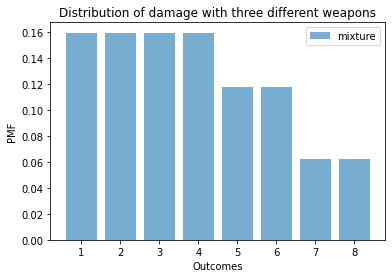

In [74]:
mix.bar(label='mixture', alpha=0.6)
plt.title('Distribution of damage with three different weapons')
plt.xlabel('Outcomes')
plt.ylabel('PMF')
plt.legend(['mixture'])

# **Summary**
This chapter introduces the Cdf object, which represents the cumulative distribution function (CDF).

A Pmf and the corresponding Cdf are equivalent in the sense that they contain the same information, so you can convert from one to the other.
The primary difference between them is performance: some operations are faster and easier with a Pmf; others are faster with a Cdf.

In this chapter we used Cdf objects to compute distributions of maximums and minimums; these distributions are useful for inference if we are given a maximum or minimum as data. You will see some examples in the exercises, and in future chapters. We also computed mixtures of distributions, which we will use in the next chapter to make predictions.

But first you might want to work on these exercises.